Q. is the decoding accuracy better for expected vs unexpected trials?

Methods:
1. apply NPS ROI mask
2. extract patterns and classify based on expect/unexpect trials
3. calcualate accuracy and f1 scores
4. 




In [1]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py


from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker


import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nntdata

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## load nifti files

In [2]:
# main_dir = '/Users/h/Documents/projects_local/cue_expectancy'
# singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/'
# save_discovery_dir= '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'

# # glob files
# subdirectories = sorted(glob.glob(join(singletrial_dir, "sub-*")))
# flists = []
# for subdir in subdirectories:
#     sub = os.path.basename(subdir)
#     flist = glob.glob(join(singletrial_dir, sub, 
#                            f"{sub}_ses-*_run-*_runtype-*_event-cue_trial-*_cuetype-*.nii.gz"))
#     flists.append(flist)

# flattened_list = [item for sublist in flists for item in sublist]
# flattened_list[0]

'/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0002/sub-0002_ses-03_run-01_runtype-vicarious_event-cue_trial-001_cuetype-high.nii.gz'

In [ ]:
# main_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue'
# singletrial_dir = join(main_dir, 'analysis/fmri/nilearn/singletrial_rampupplateau')
# save_discovery_dir= join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-NPS')

# # glob files
# subdirectories = sorted(glob.glob(join(singletrial_dir, "sub-*")))
# flists = []
# for subdir in subdirectories:
#     sub = os.path.basename(subdir)
#     flist = glob.glob(join(singletrial_dir, sub, 
#                            f"{sub}_ses-*_run-*_runtype-*_event-stimulus_trial-*_cuetype-*.nii.gz"))
#     flists.append(flist)

# flattened_list = [item for sublist in flists for item in sublist]
# flattened_list[0]

In [ ]:
# from nilearn.masking import apply_mask
# from nilearn.image import load_img
# import numpy as np


# main_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue'
# singletrial_dir = join(main_dir, 'analysis/fmri/nilearn/singletrial_rampupplateau')
# save_discovery_dir= join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-NPS')

# # glob files
# subdirectories = sorted(glob.glob(join(singletrial_dir, "sub-*")))
# flists = []
# for subdir in subdirectories:
#     sub = os.path.basename(subdir)
#     flist = glob.glob(join(singletrial_dir, sub,
#         f"{sub}_ses-*_run-*_runtype-*_event-stimulus_trial-*_cuetype-*.nii.gz"))
#     flists.append(flist)

# flattened_list = [item for sublist in flists for item in sublist]




# mask_img = load_img('/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/atlas/npsneg_rLOC.nii')  # Adjust path as necessary
# mni_template = datasets.load_mni152_template(resolution=3) # load MNI
# resampled_mask_mni = image.resample_to_img(mask_img, mni_template, interpolation='nearest')

# masked_data_list = []

# for img_path in flattened_list:
#     img = load_img(img_path)
#     resampled_nifti = image.resample_to_img(img, mni_template, interpolation='nearest')
#     masked_data = apply_mask(img, resampled_mask_mni)
#     masked_data_list.append(masked_data)

#     # Optionally, immediately process masked_data and then discard it to save memory


## check properties of mask

In [ ]:
image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npsneg_lLOC.nii').get_fdata()

In [30]:
np.unique(image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npsneg_lLOC.nii').get_fdata())

array([0., 1.])

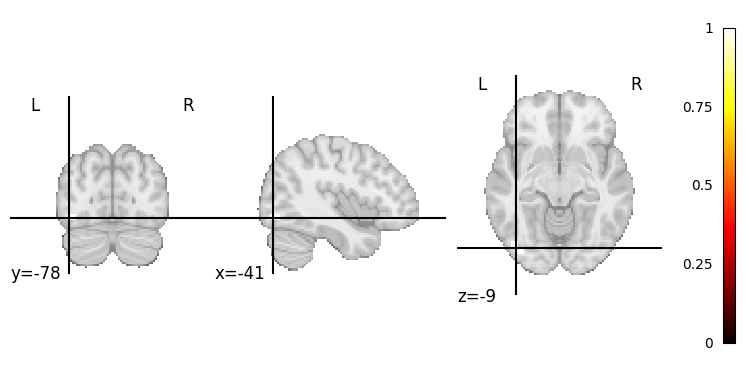

In [32]:
plotting.plot_stat_map(image.load_img('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/npsneg_lLOC.nii'))

In [37]:
from nilearn.input_data import NiftiMasker

# load mask, resample to mni 3mm and fit _______________________________________
mask_img_path = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/atlas/npsneg_rLOC.nii'
mni_template = datasets.load_mni152_template(resolution=3) # load MNI
resampled_mask_mni = image.resample_to_img(mask_img, mni_template, interpolation='nearest')
masker = NiftiMasker(mask_img=resampled_mask_mni)
masker.fit()

# For each NIfTI file, transform them into 2D arrays ___________________________
resampled_nifti_files = [image.resample_to_img(file, mni_template) for file in flattened_list]
masked_niftiarray = [masker.transform(file) for file in resampled_nifti_files]

In [96]:
npsneg_lLOC = np.vstack(masked_niftiarray)
singletrial_fname = [os.path.basename(fname) for fname in flattened_list]
npsneg_lLOCdf = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        return metadata
    return {}
metadata_df = pd.DataFrame(npsneg_lLOCdf['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npsneg_lLOCdf], axis=1)


prefix = "NPSneg_lLOC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npsneg_lLOCdf = pd.concat([metadata_df, arraydf], axis=1)

# combined brain data with metadata


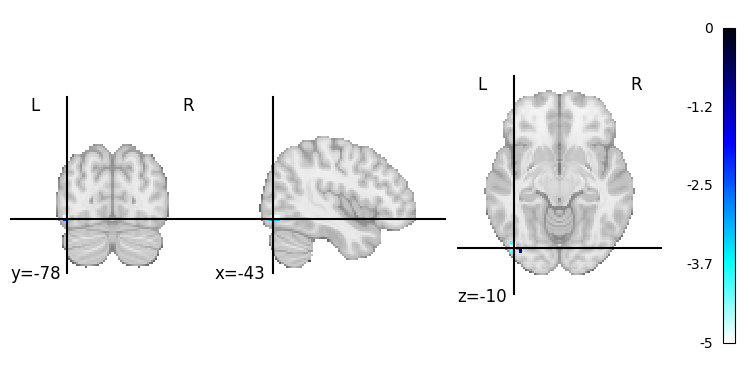

In [38]:
# Assuming 'masked_array' has been modified or analyzed and you want to project it back
nifti_from_array = masker.inverse_transform(masked_niftiarray[0])
plotting.plot_stat_map(nifti_from_array)

In [97]:
npsneg_lLOCdf.head()

,sub,ses,run,runtype,event,trial,cuetype,cue,singletrial_fname,NPSneg_lLOC_0,...,NPSneg_lLOC_9,NPSneg_lLOC_10,NPSneg_lLOC_11,NPSneg_lLOC_12,NPSneg_lLOC_13,NPSneg_lLOC_14,NPSneg_lLOC_15,NPSneg_lLOC_16,NPSneg_lLOC_17,NPSneg_lLOC_18
0,sub-0002,ses-03,run-01,vicarious,cue,trial-001,high,high_cue,sub-0002_ses-03_run-01_runtype-vicarious_event...,-4.266060,...,-4.956406,-3.330063,-4.777115,-2.502362,-2.842179,-3.265618,-1.353971,-1.239563,-1.921040,-1.329975
1,sub-0002,ses-03,run-03,cognitive,cue,trial-004,high,high_cue,sub-0002_ses-03_run-03_runtype-cognitive_event...,-0.288603,...,1.824891,1.293220,0.907481,1.451925,1.508815,1.595987,1.413662,0.679386,1.608770,1.301703
2,sub-0002,ses-03,run-02,pain,cue,trial-006,high,high_cue,sub-0002_ses-03_run-02_runtype-pain_event-cue_...,-4.280744,...,-3.418663,-2.259036,-2.382655,-1.292055,-2.193433,-2.657365,0.056919,-1.566082,-1.380283,-2.391500
3,sub-0002,ses-03,run-01,vicarious,cue,trial-000,low,low_cue,sub-0002_ses-03_run-01_runtype-vicarious_event...,6.974098,...,5.448395,3.464488,4.105056,4.463082,4.417250,4.020146,3.313021,2.454030,3.556357,2.389647
4,sub-0002,ses-03,run-05,vicarious,cue,trial-011,low,low_cue,sub-0002_ses-03_run-05_runtype-vicarious_event...,0.198416,...,1.503461,0.549642,0.727053,0.136249,0.988291,1.353215,0.181702,0.254383,0.685257,0.529189


In [110]:
df_pain_highcue = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & 
(npsneg_lLOCdf['cue'] == 'high_cue') ].copy()
overall_results = []


# subset data with high cues
high_cue_pain_index = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & 
(npsneg_lLOCdf['cue'] == 'high_cue')].index

runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index


In [123]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Filter out participants with only one run
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]
# Loop over each subject
for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    

    # Ensure corresponding brain data is selected
    X = filtered_df_sub = df_sub.filter(regex=r'^NPSneg_lLOC_\d+').values
    #df_pain_highcue.filter(regex=r'^NPSneg_lLOC_\d+')[df_sub.index].values #braindf[df_sub.index]
    Y, uniques = pd.factorize(df_sub['cue'])
    
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    
    cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
    
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

elapsed_time = time.perf_counter() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()

ValueError: The number of classes has to be greater than one; got 1 class

## apply mask as 4d

In [137]:
import nibabel as nib
import numpy as np

# Assuming you have a list of mask filenames
mask_filenames = glob.glob(os.path.join('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/nps*.nii'))

# Load the first mask to get the affine matrix (assuming all masks share the same space)
first_mask_nii = nib.load(mask_filenames[0])
affine = first_mask_nii.affine

# Load all masks and stack them
all_masks = [nib.load(fname).get_fdata() for fname in mask_filenames]
four_d_mask_data = np.stack(all_masks, axis=-1)  # Stacking along the fourth dimension

# Create a new 4D NIfTI image
four_d_mask_nii = nib.Nifti1Image(four_d_mask_data, affine)

# Save the 4D mask to a new file
nib.save(four_d_mask_nii, '/Users/h/Documents/projects_local/cue_expectancy/data/atlas/NPS_combined_masks.nii.gz')
metadata = {'filenames': [os.path.basename(fname) for fname in mask_filenames]}

with open('/Users/h/Documents/projects_local/cue_expectancy/data/atlas/NPS_combined_masks.json', 'w') as file:
    json.dump(metadata, file, indent=4)

In [2]:
# once the voxels values are extracted
data_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'
npy_nps = np.load(join(data_dir, "npsneg_rLOC_event-stimulus.npy"))
npy_nps_metadata = join(data_dir, "npsneg_rLOC_event-stimulus.json")
with open(npy_nps_metadata, 'r') as file:
    npy_nps_meta = json.load(file)
# feed it through the SVM pipeline

In [6]:
npy_nps_meta['filenames']

['sub-0002_ses-03_run-02_runtype-pain_event-stimulus_trial-009_cuetype-high_stimintensity-high.nii.gz',
 'sub-0002_ses-04_run-05_runtype-cognitive_event-stimulus_trial-010_cuetype-low_stimintensity-med.nii.gz',
 'sub-0002_ses-04_run-02_runtype-cognitive_event-stimulus_trial-005_cuetype-low_stimintensity-low.nii.gz',
 'sub-0002_ses-04_run-05_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-high.nii.gz',
 'sub-0002_ses-03_run-03_runtype-cognitive_event-stimulus_trial-007_cuetype-high_stimintensity-high.nii.gz',
 'sub-0002_ses-03_run-01_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz',
 'sub-0002_ses-03_run-02_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-low.nii.gz',
 'sub-0002_ses-03_run-06_runtype-cognitive_event-stimulus_trial-010_cuetype-high_stimintensity-med.nii.gz',
 'sub-0002_ses-03_run-02_runtype-pain_event-stimulus_trial-010_cuetype-low_stimintensity-med.nii.gz',
 'sub-0002_ses-03_run-03_runtype-cognitive_eve

In [20]:
# load numpy
# load json file with metadata

# combine as pandas
# npsneg_lLOC = np.vstack(masked_niftiarray)
npsneg_lLOC = npy_nps
singletrial_fname = npy_nps_meta['filenames']
npsneg_lLOCdf = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimulusintensity>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        metadata['stim'] = metadata['stimulusintensity'] + '_stim'
        return metadata
    
    return {}
metadata_df = pd.DataFrame(npsneg_lLOCdf['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npsneg_lLOCdf], axis=1)


prefix = "NPSneg_lLOC_"
columns = [prefix + str(i) for i in range(npsneg_lLOC.shape[1])]
arraydf = pd.DataFrame(npsneg_lLOC, columns=columns)

npsneg_lLOCdf = pd.concat([metadata_df, arraydf], axis=1)

In [21]:
npsneg_lLOCdf

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSneg_lLOC_24,NPSneg_lLOC_25,NPSneg_lLOC_26,NPSneg_lLOC_27,NPSneg_lLOC_28,NPSneg_lLOC_29,NPSneg_lLOC_30,NPSneg_lLOC_31,NPSneg_lLOC_32,NPSneg_lLOC_33
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,-0.958704,0.201728,0.495010,0.683009,0.695274,0.635661,0.357644,0.444732,0.141018,0.171403
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,1.500454,0.328310,0.126696,-0.158487,-0.274005,0.016205,0.225399,-0.093383,0.315006,0.203001
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,2.434973,0.722180,0.522262,0.576915,0.657627,0.705101,0.484609,0.637905,0.109451,0.206030
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,2.067256,0.319304,0.287669,0.614313,0.797753,0.607408,0.284556,0.652486,0.187661,0.665681
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,2.197922,0.843679,0.687508,0.858181,1.136184,1.282881,0.640512,0.801624,0.201809,0.247039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,-1.641571,0.064812,0.159649,0.145020,0.013594,-0.079039,0.209078,0.221436,0.611547,0.535706
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,2.560070,1.608090,1.440841,1.184357,0.922649,0.898072,1.489451,1.282177,1.857364,1.495971
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,1.642441,1.164171,1.430658,1.790312,1.916868,1.694607,1.681959,2.105783,2.604972,2.617860
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,2.695768,1.674104,1.555156,1.463730,1.314421,1.131361,1.680134,1.624637,2.083050,1.981846


         sub  accuracy
0   sub-0015  0.333333
1   sub-0016  0.000000
2   sub-0025  0.416667
3   sub-0028  0.333333
4   sub-0029  0.250000
..       ...       ...
67  sub-0128  0.333333
68  sub-0129  0.583333
69  sub-0130  0.333333
70  sub-0132  0.500000
71  sub-0133  0.333333

[72 rows x 2 columns]


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


0.33032407407407405

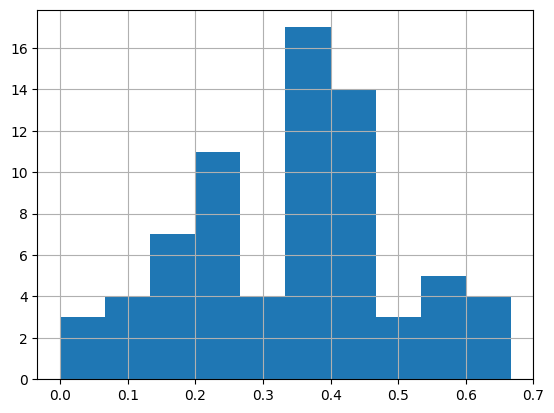

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
overall_results = []
# Filter out participants with only one run

# Loop over each subject
high_cue_pain_index = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & (npsneg_lLOCdf['cue'] == 'high_cue') & (npsneg_lLOCdf['ses'] == 'ses-01')].index
df_pain_highcue = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & (npsneg_lLOCdf['cue'] == 'high_cue')  & (npsneg_lLOCdf['ses'] == 'ses-01')].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    

    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSneg_lLOC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    
    cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
    
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()
results_df.accuracy.mean()

         sub  accuracy
0   sub-0005  0.416667
1   sub-0013  0.625000
2   sub-0014  0.166667
3   sub-0015  0.000000
4   sub-0016  0.375000
..       ...       ...
90  sub-0129  0.285714
91  sub-0130  0.417857
92  sub-0131  0.333333
93  sub-0132  0.233333
94  sub-0133  0.360714

[95 rows x 2 columns]


<Axes: >

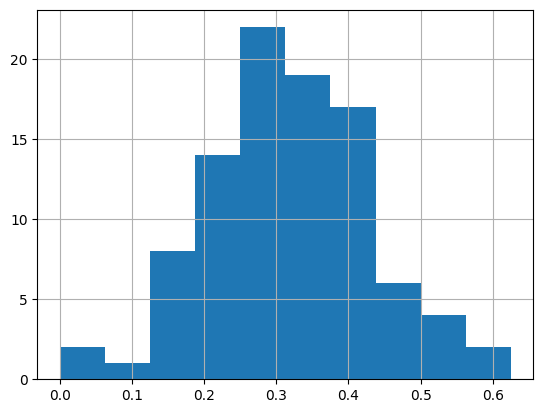

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
overall_results = []
# Filter out participants with only one run

# Loop over each subject
high_cue_pain_index = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & (npsneg_lLOCdf['cue'] == 'low_cue')].index
df_pain_highcue = npsneg_lLOCdf[(npsneg_lLOCdf['runtype'] == 'pain') & (npsneg_lLOCdf['cue'] == 'low_cue')].copy().reset_index(drop=True)
# build model per "sub"
runs_per_sub = df_pain_highcue.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = df_pain_highcue[~df_pain_highcue['sub'].isin(subs_to_drop)]

for sub in df_filtered['sub'].unique():
    # Subset data for the current subject
    df_sub = df_pain_highcue[df_pain_highcue['sub'] == sub]
    

    # Ensure corresponding brain data is selected
    X = df_sub.filter(regex=r'^NPSneg_lLOC_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])
    
    # Optionally, perform cross-validation within this subject's data
    accuracies = []
    
    cv = StratifiedKFold(n_splits=len(df_sub['run'].unique()), shuffle=True, random_state=42)
    
    for train_idx, test_idx in cv.split(X, Y):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Initialize and train the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, Y_train)
        
        # Predict and evaluate
        Y_pred = svm.predict(X_test)
        accuracies.append(accuracy_score(Y_test, Y_pred))
    
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)
    overall_results.append({'sub': sub, 'accuracy': mean_accuracy})

# Convert overall results to a DataFrame for easier analysis and visualization
results_df = pd.DataFrame(overall_results)

# elapsed_time = time.perf_counter() - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
print(results_df)
results_df.accuracy.hist()

In [29]:
results_df['accuracy'].mean()

0.3169780701754386